In [1]:
import os
os.chdir("/Coding/Spectrum4Geo/") #Change to ProjectDirectory (One Directory above)

In [2]:
import os
import torch
import importlib
import numpy as np
import spectrum4geo
import matplotlib.pyplot as plt
from dataclasses import dataclass
from torch.utils.data import DataLoader
from torchvision.utils import make_grid
from torchvision.transforms.functional import resize

from spectrum4geo.dataset.training import SatWavTrainDataset
from spectrum4geo.dataset.evaluation import SatEvalDataset, WavEvalDataset, WavEvalDataLoader
from spectrum4geo.transforms import get_transforms_train_sat, get_transforms_train_wave, get_transforms_val_sat
importlib.reload(spectrum4geo.transforms)
importlib.reload(spectrum4geo.dataset.training)
importlib.reload(spectrum4geo.dataset.evaluation)
from spectrum4geo.dataset.training import SatWavTrainDataset
from spectrum4geo.dataset.evaluation import SatEvalDataset, WavEvalDataset, WavEvalDataLoader
from spectrum4geo.transforms import get_transforms_train_sat, get_transforms_train_wave, get_transforms_val_sat

@dataclass
class Configuration:
    img_size: int = 384                         # for satallite images
    model_wav2vec: str = 'facebook/wav2vec2-base-960h'
    sr_kHz = 16
    audio_length_s = 30

    batch_size: int = 32                        # keep in mind real_batch_size = 2 * batch_size
    data_folder = "data"                        # Dataset
    
    # Augment Images
    prob_rotate: float = 0.75                   # rotates the sat image 
    prob_flip: float = 0.5                      # flipping the sat image 
    num_workers: int = 0 if os.name == 'nt' else 4 
    device: str = 'cuda' if torch.cuda.is_available() else 'cpu' 
    mean=[1, 1, 1]
    std=[1, 1, 1]

    # Shuffeling test
    shuffeling = True
    neighbour_select: int = 64                  # max selection size from pool
    neighbour_range: int = 128                  # pool size for selection
    gps_dict_path: str = 'data/gps_dict.pkl'    # path to pre-computed distances

    
config = Configuration()

img_size = config.img_size
img_size_sat = (img_size, img_size)

sat_transforms_train = get_transforms_train_sat(img_size_sat,
                                                mean=config.mean,
                                                std=config.std,
                                                )

wave_transforms_train = get_transforms_train_wave()

train_dataset = SatWavTrainDataset(data_folder=config.data_folder ,
                                   split_csv='train_df.csv',
                                   transforms_sat_image=sat_transforms_train,
                                   transforms_wave=wave_transforms_train,
                                   audio_length_s=config.audio_length_s,
                                   sr_kHz=config.sr_kHz,
                                   processor_wav2vec2=config.model_wav2vec,
                                   prob_flip=config.prob_flip,
                                   prob_rotate=config.prob_rotate,
                                   shuffle_batch_size=config.batch_size,                                                    
                                   )

train_dataloader = DataLoader(train_dataset,
                              batch_size=12,  
                              shuffle=True,
                              num_workers=config.num_workers,
                              pin_memory=True,
                              collate_fn=train_dataset.collate_fn
                              )

sat_transforms_val = get_transforms_val_sat(img_size_sat,
                                            mean=config.mean,
                                            std=config.std,
                                            )

sat_dataset_test = SatEvalDataset(data_folder=config.data_folder ,
                                  split_csv='test_df.csv',
                                  transforms=sat_transforms_val,
                                  )

sat_dataloader_test = DataLoader(sat_dataset_test,
                                 batch_size=config.batch_size,
                                 num_workers=config.num_workers,
                                 shuffle=False,
                                 pin_memory=True,
                                 )
    
wave_dataset_test = WavEvalDataset(data_folder=config.data_folder ,
                                   split_csv='test_df.csv',
                                   transforms=None,
                                   audio_length_s=config.audio_length_s,
                                   sr_kHz=config.sr_kHz,
                                   processor_wav2vec2=config.model_wav2vec,
                                   chunking = False
                                   )

wave_dataloader_test = WavEvalDataLoader(wave_dataset_test,
                                         batch_size=config.batch_size,
                                         num_workers=config.num_workers,
                                         shuffle=False,
                                         pin_memory=True,
                                         chunking = False
                                         )


print("Reference (Sat) Images Test:", len(sat_dataset_test))
print("Reference (wave) Images Test:", len(wave_dataset_test))
    
dataloader_val_tup = (wave_dataloader_test, sat_dataloader_test)

/home/j0kr0017/conda/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/home/j0kr0017/conda/lib/python3.12/site-packages/pydantic/main.py:328: UserWarning: Pydantic serializer warnings:
  Expected `Union[float, tuple[float, float]]` but got `list` - serialized value may not be as expected
  Expected `Union[float, tuple[float, float]]` but got `list` - serialized value may not be as expected
  Expected `Union[float, tuple[float, float]]` but got `list` - serialized value may not be as expected
  Expected `Union[float, tuple[float, float]]` but got `list` - serialized value may not be as expected
  return self.__pydantic_serializer__.to_python(


Reference (Sat) Images Test: 10179
Reference (wave) Images Test: 10179


Plotte Train Dataloader Bilder

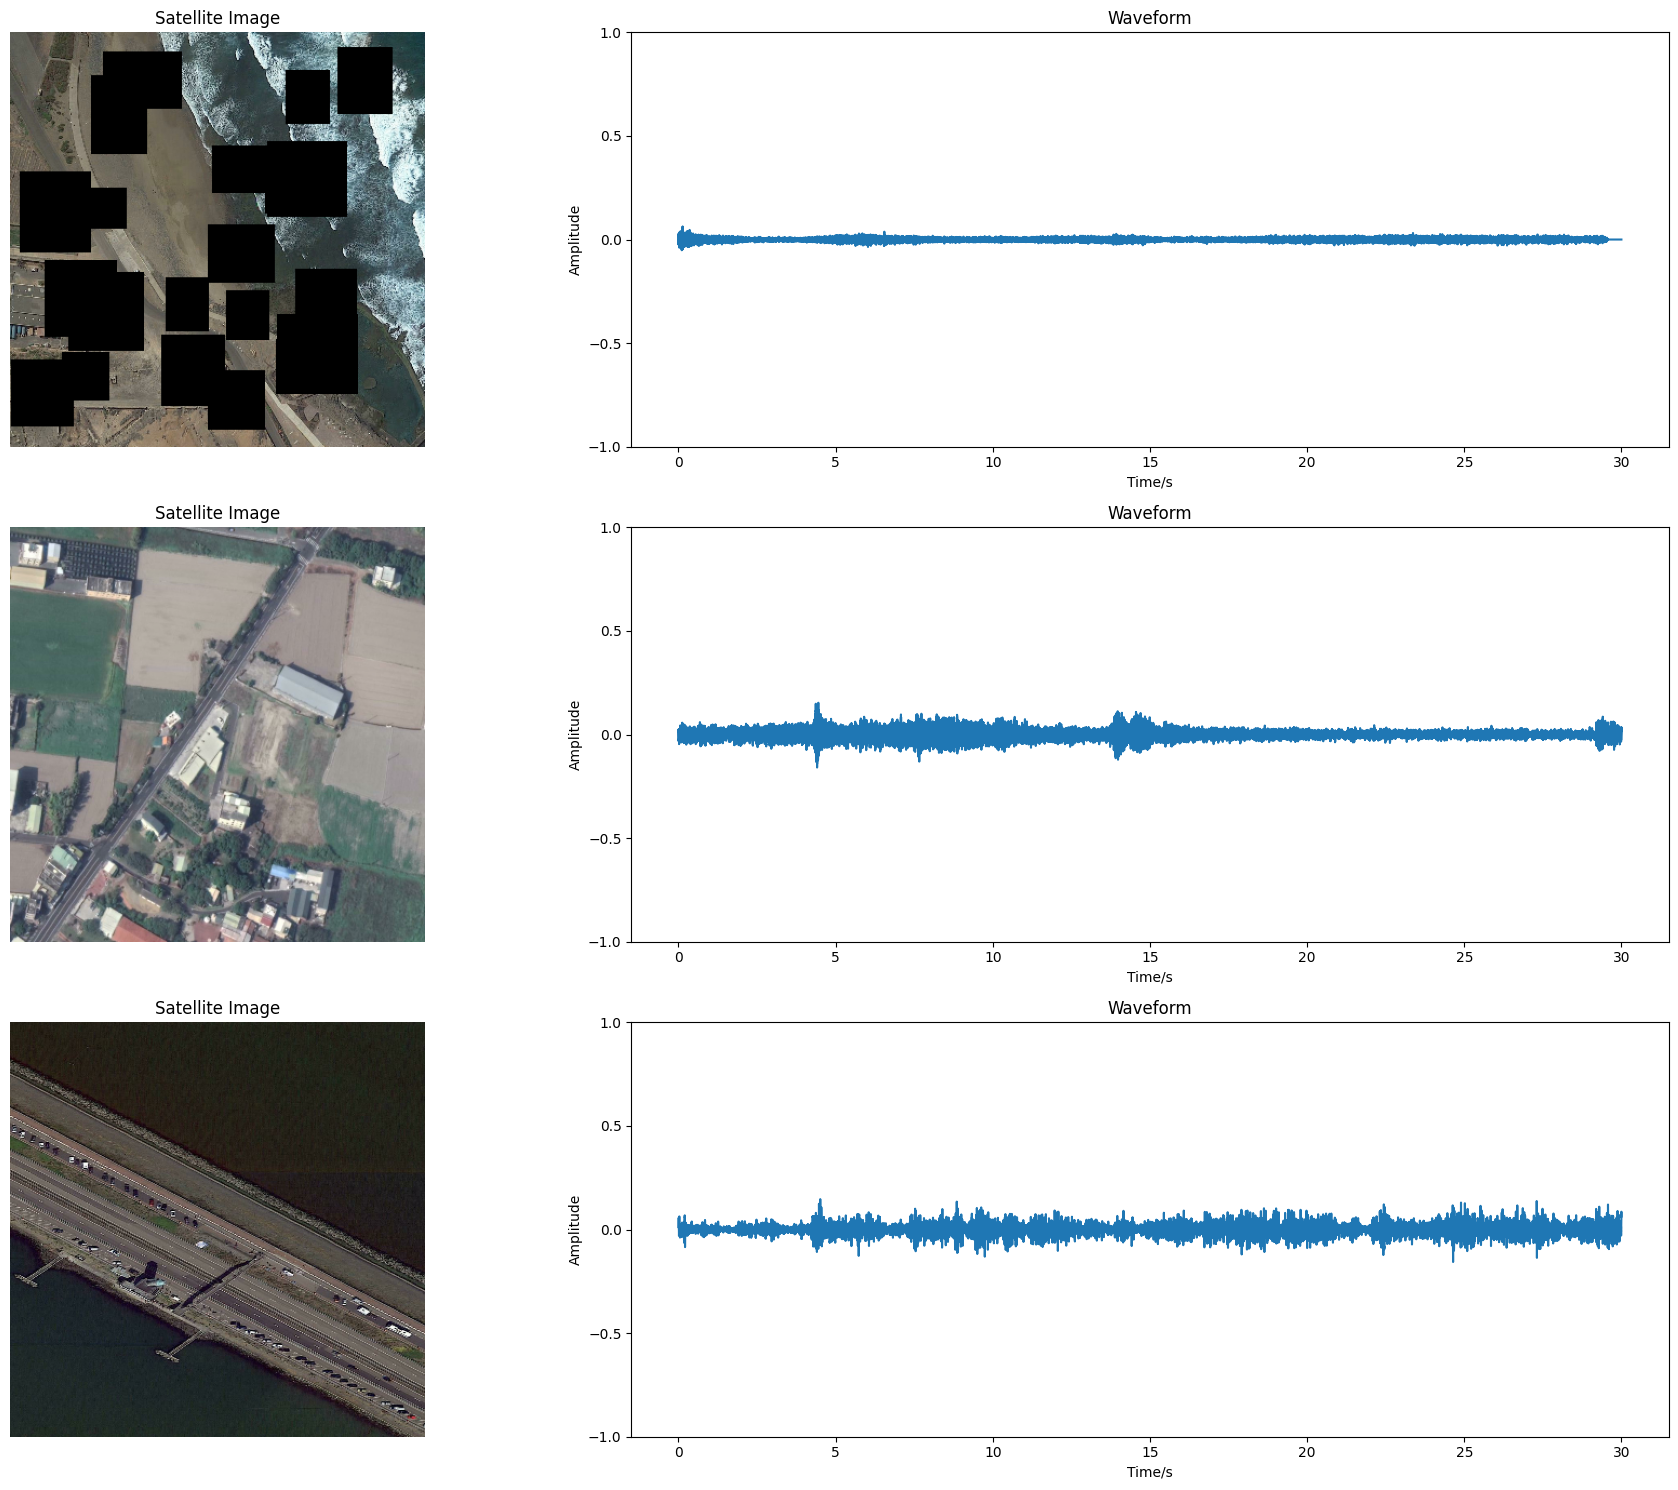

In [3]:
def denormalize(tensor, mean, std):
    for t, m, s in zip(tensor, mean, std):
        t.mul_(s).add_(m)
    return tensor

def plot_images(dataloader, num_images, sat_den_b=True):
    fig, axs = plt.subplots(nrows=num_images, ncols=2, figsize=(20, 5 * num_images))  
    axs = axs.reshape(-1, 2)  # Ensure correct shape for accessing axs

    image_count = 0
    sat_images, waves_tensors, _, _ = next(iter(dataloader))  
    batch_size = sat_images.shape[0]

    for j in range(batch_size):
        if image_count >= num_images:
            break

        sat_image = sat_images[j]
        waves_tensor = waves_tensors[j]

        if sat_den_b:
            sat_image = denormalize(sat_image, config.mean, config.std)

        # Plot satellite image
        ax_img = axs[image_count, 0]
        ax_img.imshow(sat_image.permute(1, 2, 0).numpy()) 
        ax_img.axis('off')
        ax_img.set_title('Satellite Image')

        # Plot waveform
        ax_wave = axs[image_count, 1]
        wave_data = waves_tensor.cpu().numpy()
        time_axis = torch.arange(0, len(wave_data)) / (config.sr_kHz * 1e3)
        ax_wave.plot(time_axis, wave_data)
        ax_wave.set_title('Waveform')
        ax_wave.set_xlabel('Time/s')
        ax_wave.set_ylabel('Amplitude')

        image_count += 1

    # Standardize y-axis for all waveform plots
    max_amplitude = 1#round(max(ax_wave.get_ylim()[1] for ax_wave in axs[:, 1]))
    min_amplitude = -1#round(min(ax_wave.get_ylim()[0] for ax_wave in axs[:, 1]))
    for ax_wave in axs[:, 1]:
        ax_wave.set_ylim(min_amplitude, max_amplitude)
        ax_wave.set_yticks(np.linspace(min_amplitude, max_amplitude, 5))

    plt.tight_layout()
    plt.show()

# Example usage
plot_images(train_dataloader, 3, sat_den_b=True)

Plotte Eval Dataloader Bilder

Column: 1, Satellite: 0, Wave: 0
Column: 2, Satellite: 1, Wave: 1
Column: 3, Satellite: 2, Wave: 2


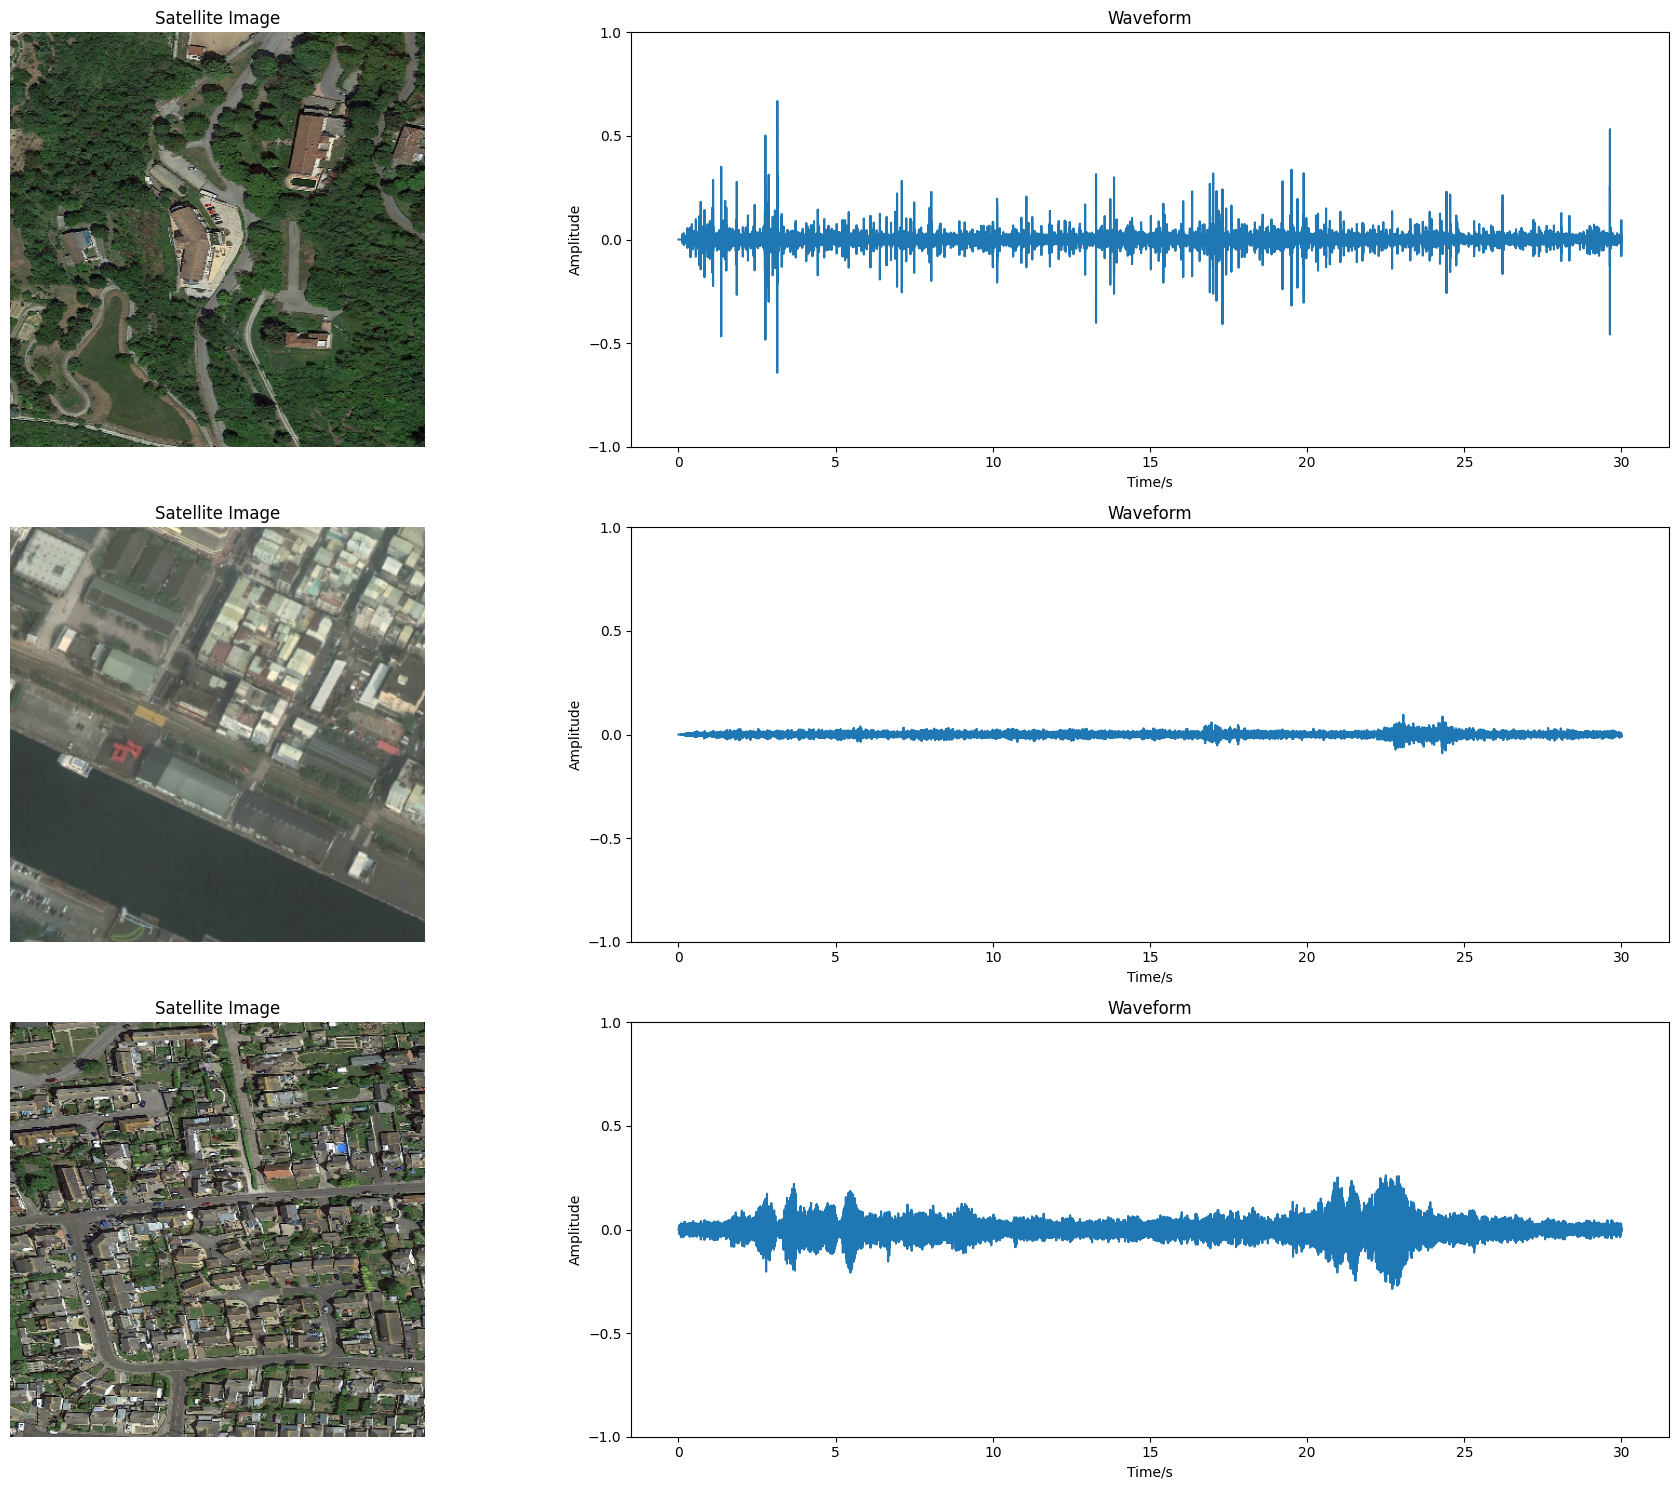

In [4]:
def plot_images_eval(dataloader_tup, num_images, sat_den_b=True):
    fig, axs = plt.subplots(nrows=num_images, ncols=2, figsize=(20, 5 * num_images))  
    axs = axs.reshape(-1, 2)  # Ensure correct shape for accessing axs
    image_count = 0

    wave_dataloader_test, sat_dataloader_test = dataloader_tup  # Unpack the tuple

    waves_tensors, _, wave_labels = next(iter(wave_dataloader_test))  
    sat_images, sat_labels = next(iter(sat_dataloader_test)) 

    for waves_tensor, sat_image, wave_label, sat_label in zip(waves_tensors, sat_images, wave_labels, sat_labels):            

        if sat_den_b:
            sat_image = denormalize(sat_image, config.mean, config.std)

        # Plot satellite image
        ax_img = axs[image_count][0]
        ax_img.imshow(sat_image.permute(1, 2, 0).cpu().numpy()) 
        ax_img.axis('off')
        ax_img.set_title('Satellite Image')

        # Plot waveform
        ax_wave = axs[image_count][1]
        wave_data = waves_tensor.cpu().numpy()
        time_axis = torch.arange(0, len(wave_data)) / (config.sr_kHz * 1e3)
        ax_wave.plot(time_axis, wave_data)
        ax_wave.set_title('Waveform')
        ax_wave.set_xlabel('Time/s')
        ax_wave.set_ylabel('Amplitude')

        image_count += 1
        
        # print labels of the combined image
        print(f'Column: {image_count}, Satellite: {sat_label}, Wave: {wave_label}')

        if image_count >= num_images:
            break

    # Standardize y-axis for all waveform plots
    max_amplitude = round(max(ax_wave.get_ylim()[1] for ax_wave in axs[:, 1]))
    min_amplitude = round(min(ax_wave.get_ylim()[0] for ax_wave in axs[:, 1]))
    for ax_wave in axs[:, 1]:
        ax_wave.set_ylim(min_amplitude, max_amplitude)
        ax_wave.set_yticks(np.linspace(min_amplitude, max_amplitude, 5))

    plt.tight_layout()
    plt.show()

plot_images_eval(dataloader_val_tup, 3,  sat_den_b = True)

In [5]:
importlib.reload(spectrum4geo.dataset.evaluation)
from spectrum4geo.dataset.evaluation import SatEvalDataset, WavEvalDataset, WavEvalDataLoader

wave_dataset_test_no_chunk = WavEvalDataset(data_folder=config.data_folder ,
                                            split_csv='test_df.csv',
                                            transforms=None,
                                            audio_length_s=config.audio_length_s,
                                            sr_kHz=config.sr_kHz,
                                            processor_wav2vec2=config.model_wav2vec,
                                            chunking = False,
                                            stride_s=config.audio_length_s/3
                                            )

wave_dataloader_test_chunk = WavEvalDataLoader(wave_dataset_test_no_chunk,
                                               batch_size=config.batch_size,
                                               num_workers=config.num_workers,
                                               shuffle=False,
                                               pin_memory=True,
                                               chunking = True
                                               )

Precalculating amount of chunks: 100%|██████████| 10179/10179 [06:43<00:00, 25.25it/s]


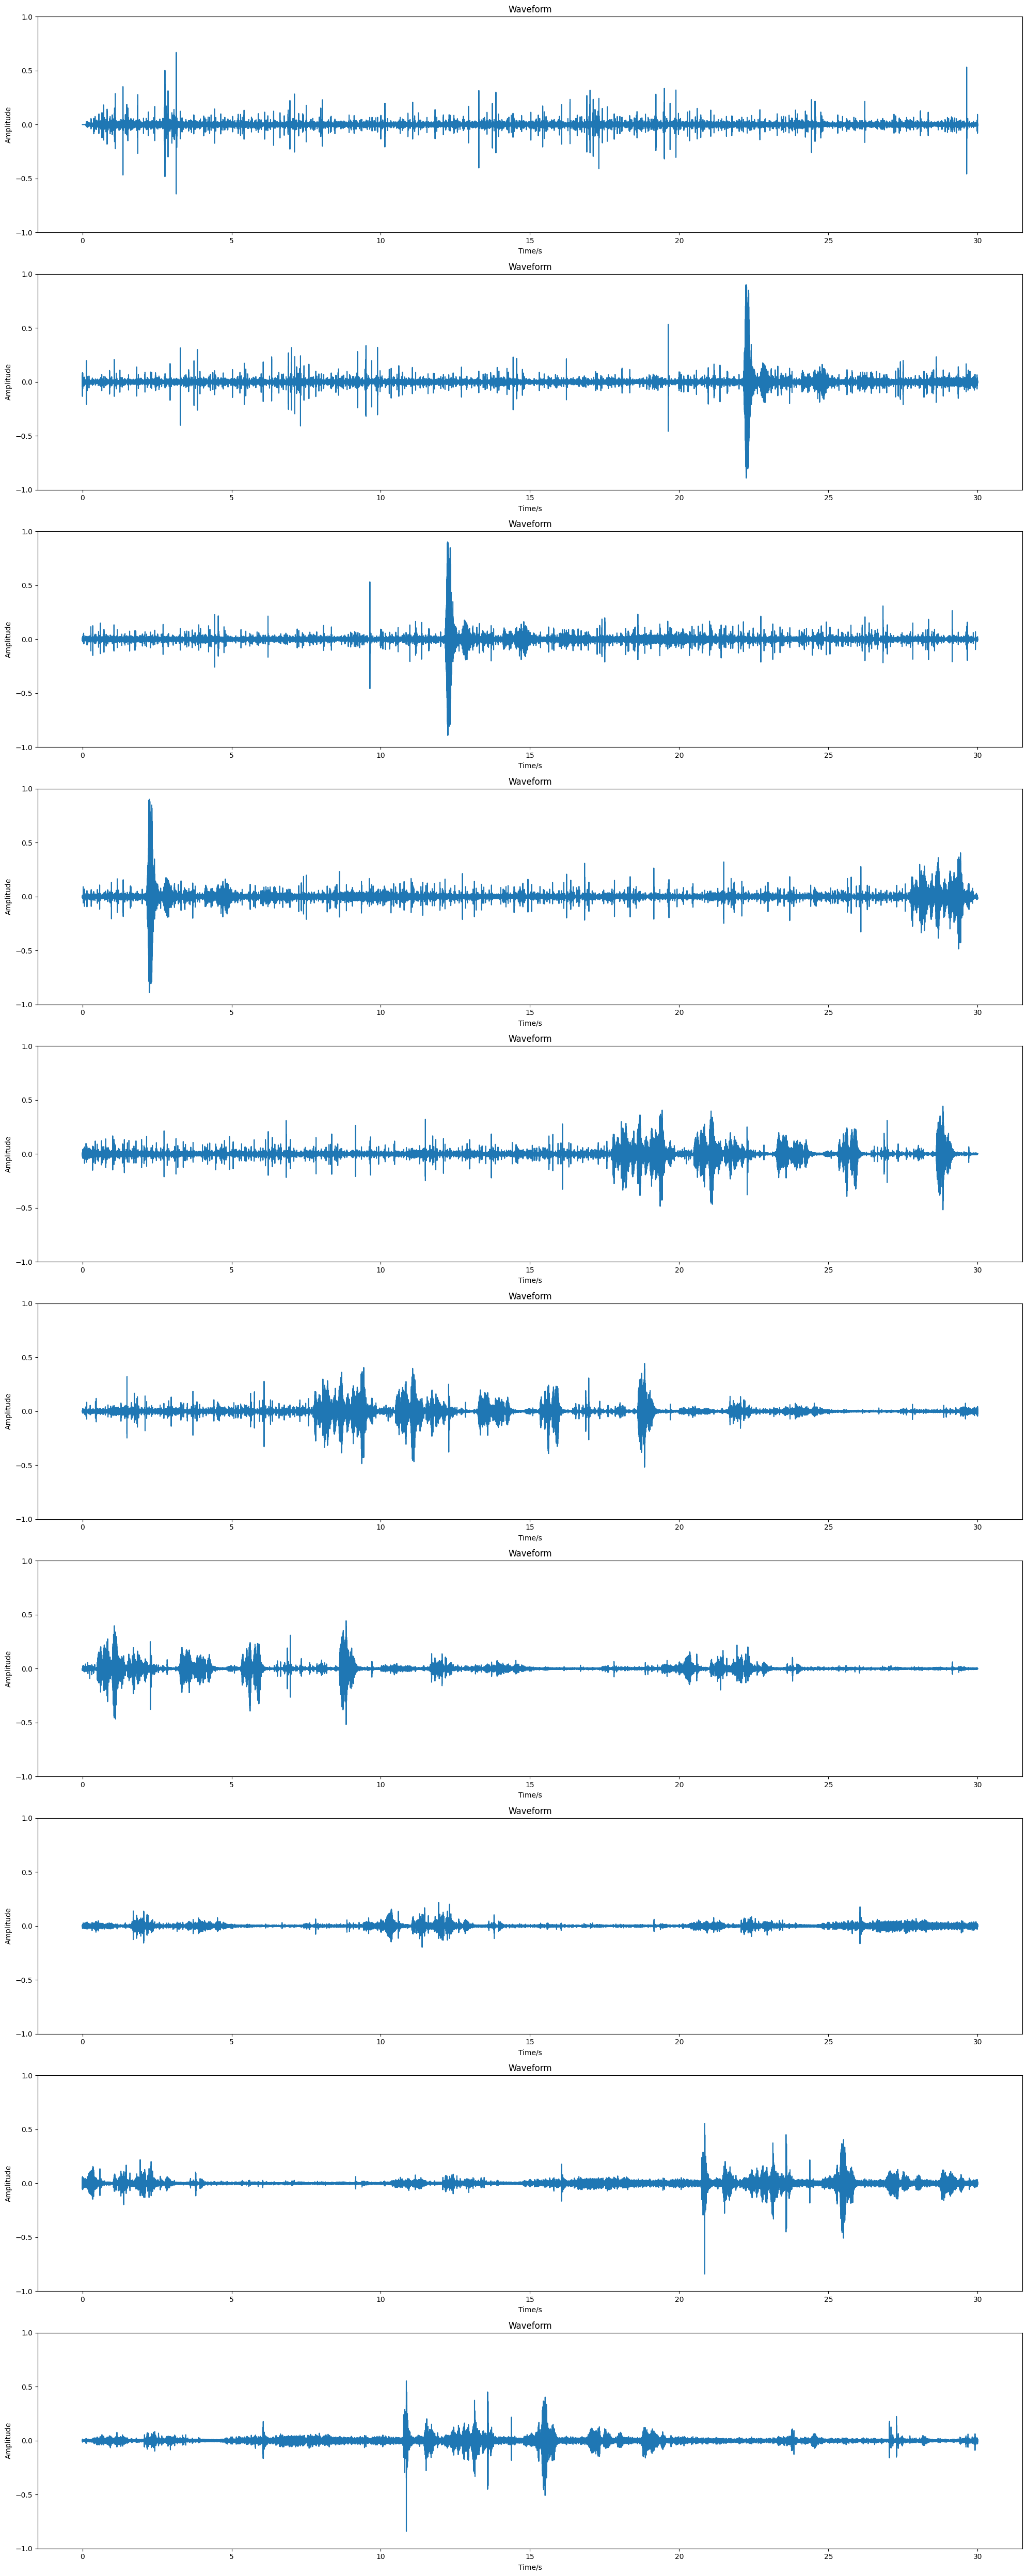

In [6]:
def plot_chunked_images(dataloader, num_images):
    fig, axs = plt.subplots(nrows=num_images, ncols=1, figsize=(20, 5 * num_images))  
    axs = axs.flatten() 

    image_count = 0
    waves_tensors, _, _, _ = next(iter(dataloader))  
    batch_size = waves_tensors.shape[0]

    for j in range(batch_size):
        if image_count >= num_images:
            break

        waves_tensor = waves_tensors[j]

        # Plot waveform
        ax = axs[image_count]
        wave_data = waves_tensor.cpu().numpy()
        time_axis = torch.arange(0, len(wave_data)) / (config.sr_kHz * 1e3)
        ax.plot(time_axis, wave_data)
        ax.set_title('Waveform')
        ax.set_xlabel('Time/s')
        ax.set_ylabel('Amplitude')

        image_count += 1

    # Standardize y-axis for all waveform plots
    max_amplitude = round(max(ax.get_ylim()[1] for ax in axs))
    min_amplitude = round(min(ax.get_ylim()[0] for ax in axs))
    for ax in axs:
        ax.set_ylim(min_amplitude, max_amplitude)
        ax.set_yticks(np.linspace(min_amplitude, max_amplitude, 5))

    plt.tight_layout()
    plt.show()

# Example usage
plot_chunked_images(wave_dataloader_test_chunk, 10)